# Introduction

Reading in wav files containing meerkat vocalisations and csv files containing the respective labeling and transforming them into different types of spectrograms. Wav files contain many vocalizations and periods of silence, and label files (CSV) indicate at what time vocalisations occur (and what type of vocalisation they are). The result is a dataframe with n_rows = number of vocalisations, metadata and different spectrogram versions (denoised, denoised_stretched, stretched, ...). What I need are spectrograms for each meerkaat vocalization. 

## Prerequisites

- Project folder should already exist, save path as PROJECT_PATH
- Project folder must contain subfolder called "in_labels", containing all label tables in csv format 
- Project folder must contain subfolder called "in_wavs", containing all audio files

### Installing and loading libraries

(software installations within Google Colaboratory are not persistent, need to reinstall libraries every time you (re-)connect to an instance)

In [4]:
import os
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
from datetime import time
from datetime import datetime
import glob
from pandas.core.common import flatten
import shutil
import pickle

In [ ]:
import os
import pandas as pd
import sys
import re
import json

import librosa
import librosa.display
from IPython.display import Audio
import numpy as np
import statistics
import matplotlib.pyplot as plt
from datetime import time
from datetime import datetime
import glob
from pandas.core.common import flatten
import shutil
import pickle
os.system('pip install pathlib2') # need to install
import pathlib2
import psutil
import datetime
from tqdm.autonotebook import tqdm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Setting constants

Setting project, input and output folders.

In [ ]:
# these directories should already exist
PROJECT_PATH = "/content/drive/My Drive/meerkat/" 
AUDIO_IN = PROJECT_PATH+"in_wavs/" 
LABELS_IN = PROJECT_PATH+"in_labels/" 

# these directories are created during execution
LABELS_OUT = PROJECT_PATH+"labels/"
FIGURES = PROJECT_PATH+"figures/"
DATA = PROJECT_PATH+"data/"
IMAGES = PROJECT_PATH+"SPECTRO_IMAGES/"

dirs2create = [LABELS_OUT, FIGURES, DATA]

# Manual encoding of the meerkat_channels for the SOUNDFOC files
os.chdir(PROJECT_PATH)
MEERKAT_CHANNEL = json.load(open("meerkat_channel.json"))
# Serialize data into file:
# json.dump(meerkat_channel, open( "meerkat_channel.json", 'w' ) )

Constants for parsing label files:

- column names in labels CSV that indicate start and duration
- irrelevant labels that are discarded in the process (labels for beeps, noise, synch calls..)
- minimum and maximum call duration in s

In [ ]:
START_COL = 'Start'
DUR_COL = 'Duration'

#IRRELEVANT_LABELS = ['SYNCH', 
#                     'START', 
#                     'END',
#                     'STOP',
#                     'SKIP', 
#                     'NOISE', 
#                     'BEEP', 
#                     'CHEW',
#                     'X',
#                     'HYB',
#                     'HYBRID',
#                     'UKN',
#                     'UNKNOWN',
#                     'FU',
#                     'LOST',
#                     'OTHER',
#                     'OTH',
#                     'LC',
#                     'SQ',
#                     'STOP',
#                     'SKIP',
#                     'NF',
#                     'NONFOC']
#IRRELEVANT_LABELS = IRRELEVANT_LABELS+[item.lower() for item in IRRELEVANT_LABELS]

MAX_DURATION=0.5
MIN_DURATION = 0.05
GROUP = 'HM'

# Spectrogramming paramters

FFT_WIN = 0.03 # FFT_WIN*samplerate = length of fft/n_fft (number of audio frames that go in one fft)
FFT_HOP = FFT_WIN/8 # FFT_HOP*samplerate = n of audio frames between successive ffts
N_MELS = 40 # number of mel bins
WINDOW = 'hann' # each frame of audio is windowed by a window function (its length can also be
# determined and is then padded with zeros to match n_fft. we use window_length = length of fft
N_MFCC = 13 # Number of cepstral coefficients

### Creating output directories

In [ ]:
os.chdir(PROJECT_PATH)

for dirpath in dirs2create:
  if not os.path.exists(os.path.basename(dirpath[:-1])):
    os.mkdir(os.path.basename(dirpath[:-1]))

## Functions

In [ ]:
# Function that gets fileID from csv filename
# Input: csv_filename (not path!) (String)
# Output: csv_filename up to the last numeric character

def fileID_from_csv_filename(csv_in):
  csv_in = csv_in[::-1]  # reverse string
  def rem_nonnumeric(str): # removes everything up to the first numeric char
    foundDigit=False
    pos=0
    for char in str:
      if(char.isdigit()):
        return(str[pos:])
      pos=pos+1
    return str 
  csv_out = rem_nonnumeric(csv_in)
  csv_out = csv_out[::-1] # reverse to normal again
  return (csv_out)
  
# Function that gets datatime object from timestring
# timestring must match one of the given time_patterns
# Input: some string containing a time (String)
# Output: datetime object
# Example usage: dt = get_time("01:02:30.555")
def get_time(timestring):
    time_patterns = ['%H:%M:%S.%f', '%M:%S.%f']
    for pattern in time_patterns:
        try:
            return datetime.datetime.strptime(timestring, pattern)
        except:
            pass

    print("Date is not in expected format")
    
    sys.exit(0)

# Function that converts time in datatime object to s 
# Input: datatime (datatime.datatime)
# Output: time in ms (float)
# Example usage: s = get_s(datatime_obj)
def get_s(dt):
  return dt.microsecond/1000000+dt.second + dt.minute*60 + dt.hour*60*60
  
  
# Function to get the meerkat ID (alphanumeric String) from filename
# filename is always HM_meerkatID_*.extension
# Input: filename (String)
# Output: meerkat ID (String)
# Example use: get_meerkatID('HM_VHMM003_HLT_AUDIO_R12_file_5_(2017_08_06-06_44_59)_ASWMUX221102.wav')

def get_meerkatID(filename):
  meerkatID = filename.replace(GROUP+'_','')
  meerkatID = str.split(meerkatID, sep='_')[0]
  return meerkatID

# Function to get date from filename
# date in filename must be in one of the three patterns
# Input: filename (String)
# Output: datetime object
# Example use: get_datetime('HM_VHMF001_HTB_R20_20190707-20190719_file_9_(2019_07_15-11_44_59)_155944')

def get_datetime(filename):
  match = re.search('\d{4}-\d{2}-\d{2}', filename)
  if (match):
    #date = datetime.strptime(match.group(), '%Y-%m-%d').date()
    date = datetime.datetime.strptime(match.group(), '%Y-%m-%d').date()
  else:
    match = re.search('\d{4}_\d{2}_\d{2}', filename)
    if (match):
     #date = datetime.strptime(match.group(), '%Y_%m_%d').date() 
     date = datetime.datetime.strptime(match.group(), '%Y_%m_%d').date() 

    else:
      match = re.search('\d{4}\d{2}\d{2}', filename)
      if(match):
        #date = datetime.strptime(match.group(), '%Y%m%d').date()
        date = datetime.datetime.strptime(match.group(), '%Y%m%d').date()
  return date


# Function that produces a labeltable from given csv+wav pairing
# Input: csv_file location (String), wav_file location (String), fileID (String)
# Output: labeltable (pd dataframe)

def prep_labels(csv_loc, wav_loc, fileID):

  # read in labels
  labels = pd.read_csv(csv_loc, sep="\t")

  # find name of column that contains the labels. Should contain 'Name'
  name_col = [col for col in labels.columns if 'Name' in col]
  if(len(name_col)==1):
    name_col = name_col[0]
    #call = ["n" if any(s in i for s in IRRELEVANT_LABELS) else "y" for i in list(labels[name_col])]
    #labels['call_yn'] = call
  else:
    print("Cannot find label name column")
  
  # Add start stop s
  if (labels.shape[0]!=0):
    labels['start_s'] = labels.apply(lambda row: get_s(get_time(row['Start'])), axis=1)
    labels['duration_s'] = labels.apply(lambda row: get_s(get_time(row['Duration'])), axis=1)
    labels['stop_s'] = labels['start_s']+labels['duration_s']

    # Add additional data
    labels['date']=[get_datetime(fileID).strftime("%Y-%m-%d")]*labels.shape[0]
    labels['samplerate_hz'] = [librosa.get_samplerate(wav_loc)]*labels.shape[0]
    labels['indv'] = [get_meerkatID(fileID)]*labels.shape[0]
    labels["original_wav"] = [wav_loc]*labels.shape[0]
    labels["bout_number"] = [i for i in range(labels.shape[0])]

  labels = labels.rename(columns={name_col: 'Name'})

  return labels

# Function that gets audio data (numpy array of amplitude) from wav
# If "SOUNDFOC" is in filename, assumes that audio is stereo and 
# looks up the channel with meerkat vocalizations in MEERKAT_CHANNEL dictionary.
# Else assumes mono.
# Input: Path to wav file (String),
#        offset in s (Float),
#        duration in s (Float)
# Output: Amplitude (numpy array)

def get_audio(wav_loc, start_s, duration_s):
  # SOUNDFOCs are stereo
  if "SOUNDFOC" in wav_loc:
    data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None, mono=False)
    data = np.asfortranarray(data[MEERKAT_CHANNEL[wav_loc],:])
  else:
    data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None)

  if np.issubdtype(type(data[0]), np.integer):
    data = data.astype('float32') # hope this will work
    #data = int16_to_float32(data) # this was the original version but must have deleted this function!? 
  return data


# Function that generates mel spectrogram from audio data
# Input: data: Audio data (np array of floats), 
#        rate: samplerate in Hz (integer)
#        n_mels: number of mel bands (integer)
#        window: spectrogram window generation type (String)
#        fft_win: window length in s (float)
#        fft_hop: hop between window start in s (float)
# Output: Spectrogram (np array of floats)

def generate_mel_spectrogram(data, rate, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * rate) 
    hop_length = int(fft_hop * rate) 
        
    s = librosa.feature.melspectrogram(y = data ,
                                       sr = rate, 
                                       n_mels = n_mels , 
                                       fmax = 4000, 
                                       n_fft = n_fft,
                                       hop_length = hop_length, 
                                       window = window, 
                                       win_length = n_fft)

    spectro = librosa.power_to_db(s, ref=np.max)

    return spectro

## Processing files

### Setting variables

Getting list of csvs and matching wavs

In [ ]:
# Getting list of fileIDs, wavs and csvs (fileID, in_wav_loc and in_csv_loc)

in_csv_loc = glob.glob(LABELS_IN+'*.csv') + glob.glob(LABELS_IN+'*.CSV')
csv_filenames = [os.path.basename(csv) for csv in in_csv_loc]

fileIDs = [fileID_from_csv_filename(csv_filename) for csv_filename in csv_filenames]

in_wav_loc = [glob.glob(AUDIO_IN+fileID+'*') for fileID in fileIDs] # creates list of lists
in_wav_loc = [["NA"] if not x else x for x in in_wav_loc] # Replace empty lists with "NA"
in_wav_loc = list(flatten(in_wav_loc)) # Flatten list

### Removing bad quality files

Removing files with bad quality

In [ ]:
badIDs = ['HM_VHMM007_LT_AUDIO_R11_file_5_(2017_08_06-06_44_59)_ASWMUX221163', 
           'HM_VHMM006_RT_AUDIO_R14_file_5_(2017_08_06-06_44_59)_ASWMUX221052']

In [ ]:
bad_csvs = [glob.glob(LABELS_IN+fileID+'*') for fileID in badIDs]
bad_csvs = list(flatten(bad_csvs))

bad_wavs = []
for bad_csv in bad_csvs:
  bad_wavs.append(in_wav_loc[in_csv_loc.index(bad_csv)])

for bad_csv in bad_csvs:
  in_csv_loc.remove(bad_csv)
for bad_wav in bad_wavs:
  in_wav_loc.remove(bad_wav)
for badID in badIDs:
  fileIDs.remove(badID)


In [ ]:
print(str(len(fileIDs))+" files remaining") # all files

114 files remaining


### Generating label files

In [ ]:
for csv, wav, fileID in zip(in_csv_loc, in_wav_loc, fileIDs):
  if not wav=='NA':
    print("Processing "+fileID)
  # Parse labels
    labels = prep_labels(csv, wav, fileID)  
    # If labels is non-empty...
    if (labels.shape[0]!=0):
      labels.to_csv(LABELS_OUT+fileID+"_labels.csv", index=False)
    else:
      print("No labelled calls for "+fileID)
  else:
    print("No wav for "+fileID)

Processing HM_RT_R12_file_6_(2017_08_25-06_44_59)_ASWMUX221102
Processing HM_VLF206_SOUNDFOC_20170825_2
Processing HM_VHMM003_SOUNDFOC_20170825_2
Processing HM_VHMM003_SOUNDFOC_20170825_3
Processing HM_HRT_R09_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221110
Processing HM_LT_R07_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221092
Processing HM_HTB_R14_file_6_(2017_08_25-06_44_59)_ASWMUX221052
Processing HM_PET_R11_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221163
Processing HM_HMB_R11_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221163
Processing HM_RT_R12_file_4_(2017_08_23-06_44_59)_ASWMUX221102
Processing HM_VLF206_SOUNDFOC_20170824_1
Processing HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163
Processing HM_HRT_R09_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221110
Processing HM_LT_R07_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221092
Processing HM_HRT_R09_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221110
Processing HM_VLF206_SOUNDFOC_20170823_1
Processing HM_RT_R12_

In [ ]:
print("Generated "+str(len(glob.glob(LABELS_OUT+'*')))+" label files") # all

Generated 108 label files


### Get updated list of wav and labels file locations

In [ ]:
# List of all wav filepaths (to full wav files, not just the calls), where I have 
# a labels file in LABELS_OUT. Therefore, do it kind of backwards.

labels_loc = glob.glob(LABELS_OUT+'*.csv')
fileIDs = [os.path.basename(item).replace('_labels.csv', '') for item in labels_loc] 

wavs_loc = [glob.glob(AUDIO_IN+fileID+'*') for fileID in fileIDs] # creates list of lists
wavs_loc = [["NA"] if not x else x for x in wavs_loc] # Replace empty lists with "NA"
wavs_loc = list(flatten(wavs_loc)) # Flatten list

# check for NAs, should be none!
for ID, wav in zip(fileIDs, wavs_loc):
  if wav=="NA":
    print("Error, wav file missing for"+label)


### Make a dataframe for the whole dataset

In [ ]:
df_list=[]

for label_loc in labels_loc:
  print("Reading label df for "+os.path.basename(label_loc))
  df_list.append(pd.read_csv(label_loc))

df = pd.concat(df_list)

In [ ]:
df.shape 

(46009, 15)

In [ ]:
df = pd.concat(df_list)

### Cleaning dataset

#### Removing noisy, uncertain calls and categorizing

In [ ]:
df['Name'].unique()

array(['START', 'BEEP 1:00:00', 'SYNCH 1:00:00', ..., 'CCX   ',
       'SYNCH 1:48:00?', 'HYB (SOC+CC)'], dtype=object)

In [ ]:
lablenames = df['Name']

call_types = {
    'cc' :["cc","Marker", "Marque", "CC", "MARKER", "MARQUE"],
    'sn' :["sn","subm", "short","^s$", "s ", "SN", "SUBM", "SHORT", "S"], 
    'mo' :["mo", "mov", "move", "MO","MOV","MOVE"],
    'agg':["ag", "agg", "aggress", "chat", "growl","AG","AGG","AGGRESS","CHAT","GROWL"],
    'ld' :["ld","LD","lead","LEAD"],
    'soc':["soc","SOCIAL", "so ", "SOC", "social"], 
    'al' :["al", "AL","ALARM", "alarm"],
    #'fu/hyb': ["fu", "FU", "Fu", 'HYB', 'hyb', 'Hyb']
    }
    
# make dictionary labels to calls
labels_to_calls = dict((v,k) for k in call_types for v in call_types[k])

- Remove all that contain # (unsure if it's even a call)

In [ ]:
print(np.sum(np.asarray([1 if '#' in i else 0 for i in lablenames])))
lablenames = ["other" if '#' in i else i for i in lablenames]

286


- Remove noisy calls (marked with "X" or "x")

In [ ]:
print(np.sum(np.asarray([1 if (('x' in i) or ('X' in i)) else 0 for i in lablenames])))
lablenames = ["other" if (('x' in i) or ('X' in i)) else i for i in lablenames]

3834



*   Added later: differentiate certain and uncertain calls



In [ ]:
certain_yn = ["n" if ('?' in i) else "y" for i in lablenames]
certain_yn.count('n')

765

- Ignore "?", "!","*" and "%" (? expresses uncertainty about label, * expresses uncertainty about nonfocal or focal, don't know what ! means, % means overlapping calls)

In [ ]:
labelsep = re.compile('[\?\*\!%]') # Match ? * ! %
lablenames = [labelsep.sub('', i) for i in lablenames]

- String split and use first word for categorization based on dictionary

In [ ]:
firstword = [i.split(' ')[0] for i in lablenames]
lables = [labels_to_calls[lable] if lable in labels_to_calls.keys() else "unknown" for lable in firstword]

In [ ]:
pd.Series(lables).value_counts()

cc         19592
unknown    15837
soc         3963
sn          3818
mo           999
al           801
agg          790
ld           209
dtype: int64

*   Added later: differentiate focal and nonfocal calls

In [ ]:
# this is how I did it the first time:
secondword = [i.split(' ')[1] if len(i.split(' '))>1 else 'focal' for i in lablenames]
nonfocal_yn = ['y' if i in ['nf', 'NF', 'NONFOC', 'nonfoc'] else 'n' for i in secondword]

In [ ]:
# this is how I would do it now, leads to slightly different results:
#nonfocal_yn = ['y' if any(substring in i for substring in ['nf', 'NF', 'NONFOC', 'nonfoc']) else 'n' for i in lablenames]

Write to df

In [ ]:
df['call_lable'] = lables
df['certain_yn'] = certain_yn
df['nonfocal_yn'] = nonfocal_yn

In [ ]:
#df_fu = df[df['call_lable']=='fu/hyb']
#df.to_pickle(PROJECT_PATH+"df_fu")

In [ ]:
df.to_pickle(PROJECT_PATH+"final_df_all")

#### Removing non-calls (beep, synch etc..)

In [ ]:
df = pd.read_pickle(PROJECT_PATH+"final_df_all")

In [ ]:
call = df['call_lable']!="unknown"
call_yn = ['y' if x else 'n' for x in call]
df['call_yn'] = call_yn

In [ ]:
df = df.loc[df['call_yn']=="y"]
df.shape

(30172, 19)

In [ ]:
df['call_lable'].value_counts()

cc     19592
soc     3963
sn      3818
mo       999
al       801
agg      790
ld       209
Name: call_lable, dtype: int64

#### Removing non-focal calls

The first time, I had actually NOT removed the non-focal calls at this point. But later it turned out, that we don't use them so I've removed them from the dataset AFTER.

In [ ]:
#df = df.loc[df['nonfocal_yn']=="n"]
#df.shape

(22472, 19)

In [ ]:
#df['call_lable'].value_counts()

cc     15057
sn      3666
soc     1407
mo       823
al       725
agg      603
ld       191
Name: call_lable, dtype: int64

#### Removing long and short calls

In [ ]:
df.shape

(30172, 19)

In [ ]:
np.mean(df['duration_s'])

0.14492400238631897

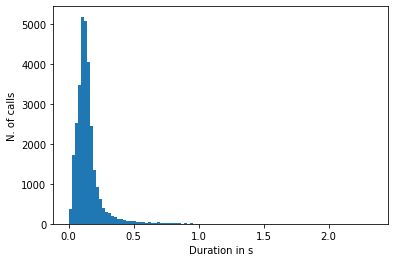

In [ ]:
n, bins, pathes = plt.hist(df['duration_s'], bins=100)
plt.xlabel("Duration in s")
plt.ylabel("N. of calls")
plt.savefig(FIGURES+'final/'+'duration_hist.png')

In [ ]:
print(df[df['duration_s']>MAX_DURATION].shape[0]/df.shape[0]) # % of calls > 0.5s --> 1.2 %
print(df[df['duration_s']>MAX_DURATION].shape[0])

0.017532811878562905
529


In [ ]:
print(df[df['duration_s']<MIN_DURATION].shape[0]/df.shape[0]) # % of calls < 0.5s --> 9.4 %
print(df[df['duration_s']<MIN_DURATION].shape[0])

0.07951080471960759
2399


Look at short calls

In [ ]:
short_calls = df[df['duration_s']<MIN_DURATION]
short_calls['call_lable'].value_counts()

sn        1789
cc         209
agg         67
soc         64
al          51
fu/hyb      42
mo           2
Name: call_lable, dtype: int64

In [ ]:
calltype = short_calls['call_lable'].unique()[1]
print(calltype)
example = short_calls.loc[short_calls['call_lable']==calltype,:].sample(n=1)
y, sr = librosa.load(example.original_wav.values[0], 
                     offset=example.start_s.values[0], 
                     duration=example.duration_s.values[0], sr=None)
Audio(y, rate=sr)

cc


In [ ]:
df[df['duration_s']==0].shape[0]/df.shape[0] # % of calls = 0s --> 0.05 %

0.0005634362985549517

In [ ]:
df[df['duration_s']==0].shape[0] # 17 calls of length=0 -> errors

17

In [ ]:
df = df.loc[df['duration_s'] >= MIN_DURATION]
df.shape

(27773, 19)

In [ ]:
df = df.loc[df['duration_s'] <= MAX_DURATION]
df.shape

(27244, 19)

In [ ]:
df['call_lable'].value_counts()

cc     19356
soc     3499
sn      1947
mo       995
al       748
agg      491
ld       208
Name: call_lable, dtype: int64

#### Sorting and saving
Add index, sort values and save dataframe:

In [ ]:
df.index = list(range(0,df.shape[0]))
df = df.sort_values(by=['original_wav', 'bout_number'])

df.to_pickle(PROJECT_PATH+"final_df_all_clean") # (27244, 18)
#df.to_pickle(PROJECT_PATH+"df_all_clean_fu") 

### Creating the spectrograms

Creating spectrograms from call files and put them as numpy array into labels dataframe. First, remove all signals that are not calls and all calls that are too short.



In [ ]:
spec_df = pd.read_pickle(PROJECT_PATH+"df_all_clean")

#### Getting audio data

In [ ]:
raw_audio_data = spec_df.apply(lambda row: get_audio(row['original_wav'], row['start_s'], row['duration_s']), axis=1)
spec_df['raw_audio'] = raw_audio_data

In [ ]:
subset_df = spec_df.loc[0:50,]
sylls = subset_df.raw_audio.values

nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

AttributeError: ignored

#### Spectrogramming

In [ ]:
spectrograms = spec_df.apply(lambda row: generate_mel_spectrogram(row['raw_audio'], 
                                                             row['samplerate_hz'], 
                                                             N_MELS, 
                                                             WINDOW, 
                                                             FFT_WIN , 
                                                             FFT_HOP), 
                        axis=1)

spec_df['spectrograms'] = spectrograms

In [ ]:
spec_df.shape

(1124, 20)

Visualize the first 50 spectrograms

In [ ]:
from avgn.visualization.spectrogram import draw_spec_set

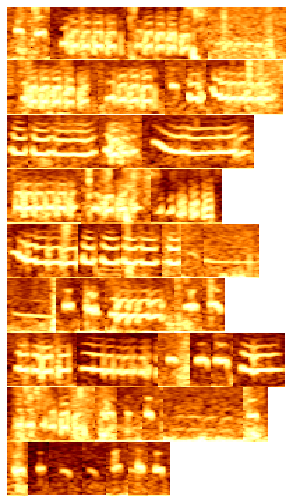

In [ ]:
df_subset = spec_df.iloc[1:50,]
specs = df_subset.spectrograms.values
draw_spec_set(specs, zoom=1, maxrows=10, colsize=5)
plt.show()

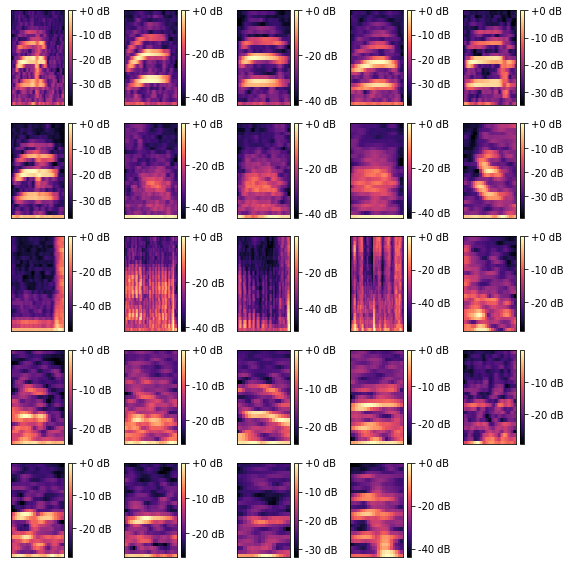

In [ ]:
# with N_MELS=25
df_subset = spec_df.iloc[1:25,]
specs = df_subset.spectrograms.values

plt.figure(figsize=(8, 8))
for i,spec in enumerate(specs,1):
  plt.subplot(5, 5, i)
  librosa.display.specshow(spec)
  plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

#### MFCCs

In [ ]:
mfccs = [librosa.feature.mfcc(S=spectro,n_mfcc=N_MFCC) for spectro in spec_df['spectrograms']]
spec_df['mfccs'] = mfccs

#### MFCC Deltas

In [ ]:
mfcc_deltas = [librosa.feature.delta(mfcc) for mfcc in spec_df['mfccs']]
spec_df['mfcc_deltas'] = mfcc_deltas

#### MFCC Delta-Deltas

In [ ]:
mfcc_deltadeltas = [librosa.feature.delta(mfcc, order=2) for mfcc in spec_df['mfccs']]
spec_df['mfcc_deltadeltas'] = mfcc_deltadeltas

### Save dataframe

Add soundfoc_yn

In [ ]:
ori_wav = spec_df['original_wav']
soundfoc_yn = ['y' if "SOUNDFOC" in i else 'n' for i in ori_wav]
spec_df['soundfoc_yn'] = soundfoc_yn

Save

In [ ]:
# changed this and df should now already be sorted
#spec_df = spec_df.sort_values(by=['original_wav', 'bout_number'])

spec_df.to_pickle(DATA+'spec_df_all')
#spec_df.to_pickle(DATA+'spec_df_all_25mels')

# Time stretch

In [ ]:
spec_df = pd.read_pickle(PROJECT_PATH+'spec_df_all')

## With vocoder

### Stretch audio data

In [ ]:
def generate_stretched_mel_spectrogram(data, sr, duration, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * sr) 
    hop_length = int(fft_hop * sr) 
    stretch_rate = duration/MAX_DURATION

    D = librosa.stft(y=data, # spectrogramming
                     n_fft = n_fft,
                     hop_length = hop_length,
                     window=window,
                     win_length = n_fft
                     )
    
    D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
    D_stretched = librosa.power_to_db(np.abs(D_stretched)**2, ref=np.max)
    
    s = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                       sr=sr,
                                       n_mels=n_mels,
                                       fmax=4000)
        
    #spectro = librosa.power_to_db(np.abs(s)**2, ref=np.max) # power to db transform

    return s

In [ ]:
# Spectrogramming
spectrograms = spec_df.apply(lambda row: generate_stretched_mel_spectrogram(row['raw_audio'],
                                                                            row['samplerate_hz'], 
                                                                            row['duration_s'],
                                                                            N_MELS,
                                                                            WINDOW,
                                                                            FFT_WIN,
                                                                            FFT_HOP),
                             axis=1)

spec_df['stretched_spectrograms'] = spectrograms

# MFCCs etc.

mfccs = [librosa.feature.mfcc(S=spectro,n_mfcc=N_MFCC) for spectro in spec_df['stretched_spectrograms']]
spec_df['stretched_mfccs'] = mfccs

mfcc_deltas = [librosa.feature.delta(mfcc) for mfcc in spec_df['stretched_mfccs']]
spec_df['stretched_mfcc_deltas'] = mfcc_deltas

mfcc_deltadeltas = [librosa.feature.delta(mfcc, order=2) for mfcc in spec_df['stretched_mfccs']]
spec_df['stretched_mfcc_deltadeltas'] = mfcc_deltadeltas

In [ ]:
spec_df.to_pickle(PROJECT_PATH+'spec_df_all_stretch_vocoder')
#spec_df.to_pickle(DATA+'spec_df_all_stretch_vocoder_25mels')

In [ ]:
# Visualize examples
df_subset = spec_df.sample(n = 5, replace=False) 

specs = df_subset.spectrograms.values
specs_stretched = df_subset.stretched_spectrograms.values

plt.figure(figsize=(12, 8))
k=1
for i in range(len(specs)):
  spec = specs[i]
  spec_stretched = specs_stretched[i]
  plt.subplot(5, 2, k)
  plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal') 
  plt.subplot(5, 2, k+1)
  plt.imshow(spec_stretched, interpolation='nearest', origin='lower', aspect='equal') 
  k=k+2
plt.tight_layout()

### Vocoder testing (single function):

In [ ]:
example_row = 100
data = spec_df.loc[example_row,'raw_audio']
duration = spec_df.loc[example_row,'duration_s']
sr = spec_df.loc[example_row,'samplerate_hz']
n_mels = N_MELS
window = WINDOW
fft_win = FFT_WIN
fft_hop = FFT_HOP

n_fft  = int(fft_win * sr) 
hop_length = int(fft_hop * sr) 
rate = duration/MAX_DURATION

In [ ]:
# Original data
print("Duration: ",duration)
Audio(data=spec_df.loc[example_row,'raw_audio'],
      rate=spec_df.loc[example_row,'samplerate_hz'])

Duration:  0.134


In [ ]:
# Fourier transform
D = librosa.stft(y=data,
                 n_fft = n_fft,
                 hop_length = hop_length,
                 window=window,
                 win_length = n_fft
                 )
D.shape

(121, 36)

In [ ]:
# Reconstruct audio from FFT
reconstructed_audio = librosa.core.istft(D,  
                                         window=window,
                                         win_length=n_fft,
                                         hop_length=hop_length)
Audio(data=reconstructed_audio, rate=spec_df.loc[example_row,'samplerate_hz'])

In [ ]:
# Stretch FFT using phase vocoder

D_stretched = librosa.core.phase_vocoder(D, rate, hop_length=hop_length)
D_stretched.shape

(121, 135)

In [ ]:
# Reconstruct audio from stretched FFT

stretched_audio = librosa.core.istft(D_stretched,  
                                     window=window,
                                     win_length=n_fft,
                                     hop_length=hop_length)

stretched_duration = librosa.core.get_duration(y=stretched_audio,
                                               sr=spec_df.loc[example_row,'samplerate_hz'])
print("Duration after stretching: ", stretched_duration)
Audio(data=stretched_audio, 
      rate=spec_df.loc[example_row,'samplerate_hz'])

Duration after stretching:  0.5025


(40, 36)
(40, 36)


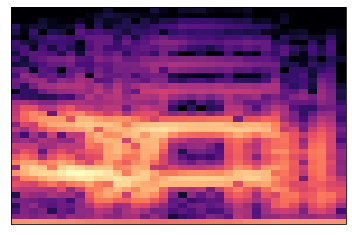

In [ ]:
# Melspectrogram of normal
s = librosa.feature.melspectrogram(S=D, 
                                   sr=sr,
                                   n_mels=n_mels,
                                   fmax=4000)
print(s.shape)
spectro = librosa.power_to_db(np.abs(s)**2, ref=np.max)
print(spectro.shape)

librosa.display.specshow(spectro)

(40, 135)
(40, 135)


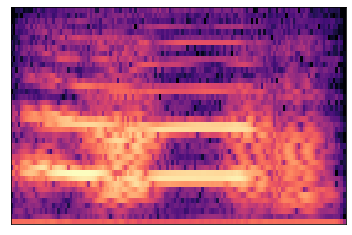

In [ ]:
# Melspectrogram of stretched
s_stretched = librosa.feature.melspectrogram(S=D_stretched, 
                                   sr=sr,
                                   n_mels=n_mels,
                                   fmax=4000)
print(s_stretched.shape)
spectro_stretched = librosa.power_to_db(np.abs(s_stretched)**2, ref=np.max)
print(spectro_stretched.shape)

librosa.display.specshow(spectro_stretched)

In [ ]:
example_row = 2000

out = generate_stretched_mel_spectrogram(spec_df.loc[example_row,'raw_audio'],
                                         spec_df.loc[example_row,'samplerate_hz'], 
                                         spec_df.loc[example_row,'duration_s'],
                                         N_MELS, 
                                         WINDOW, 
                                         FFT_WIN , 
                                         FFT_HOP)
out.shape

# Denoising

## Median subtraction

Using median subtraction to remove impulse broadband noise from the calls.

### Single example

In [ ]:
%cd noise_files/

/content/drive/My Drive/meerkat/noise_files


In [ ]:
#example_ID= 'HM_VHMF001_HTB_R20_20190707-20190719_file_10_(2019_07_16-11_44_59)_165944_labels.csv'
example_ID='HM_HTB_R14_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221052_labels.csv'
example_lable = pd.read_csv(LABELS_OUT+example_ID)

In [ ]:
example_lable

Row 4 is marked with CCX, indicating that there is noise in the call.

In [ ]:
row = 4
window = 2
offset_s = example_lable.loc[row,'start_s']
dur_s = example_lable.loc[row,'duration_s']
example_file = AUDIO_IN+example_ID[:-11]+".wav"

#data, rate = librosa.load(example_file, offset=offset_s-2, duration=dur_s+4, sr=None, mono=False)
data, rate = librosa.load(example_file, offset=offset_s, duration=dur_s, sr=None, mono=False)

Audio(data=data, rate=rate) 

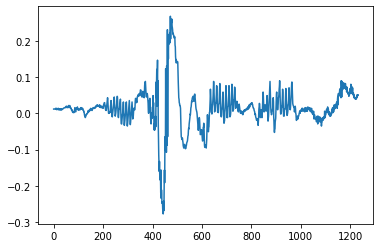

In [ ]:
raw_audio = get_audio(example_lable.loc[row,'original_wav'], example_lable.loc[row,'start_s'], example_lable.loc[row,'duration_s'])
plt.plot(raw_audio)

In [ ]:
spectrogram = generate_mel_spectrogram(raw_audio,rate,N_MELS,WINDOW,FFT_WIN,FFT_HOP)

In [ ]:
spectrogram

Text(0.5, 1.0, 'Mel spectrogram')

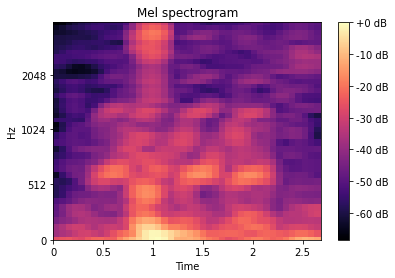

In [ ]:
librosa.display.specshow(spectrogram,sr=8000,y_axis='mel', fmax=4000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')

In [ ]:
# Median subtraction
Y = spectrogram - np.median(spectrogram, axis=0)

Text(0.5, 1.0, 'Mel spectrogram')

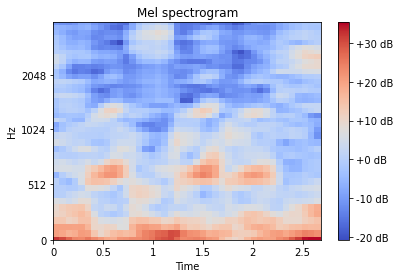

In [ ]:
librosa.display.specshow(Y,sr=8000,y_axis='mel', fmax=4000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')

### Denoise calls

In [ ]:
df = pd.read_pickle(PROJECT_PATH+'spec_df_all_stretch_vocoder')

In [ ]:
# Make spectrograms

denoised = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in df['spectrograms']]
df['denoised_spectrograms'] = denoised

denoised_stretched = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in df['stretched_spectrograms']]
df['denoised_stretched_spectrograms'] = denoised_stretched

# Make MFCCs
mfccs = [librosa.feature.mfcc(S=spectro,n_mfcc=N_MFCC) for spectro in df['denoised_spectrograms']]
df['denoised_mfccs'] = mfccs

mfccs = [librosa.feature.mfcc(S=spectro,n_mfcc=N_MFCC) for spectro in df['denoised_stretched_spectrograms']]
df['denoised_stretched_mfccs'] = mfccs

# Make MFCC Deltas
mfcc_deltas = [librosa.feature.delta(mfcc) for mfcc in df['denoised_mfccs']]
df['denoised_mfcc_deltas'] = mfcc_deltas

mfcc_deltas = [librosa.feature.delta(mfcc) for mfcc in df['denoised_stretched_mfccs']]
df['denoised_stretched_mfcc_deltas'] = mfcc_deltas

Save dataframe

In [ ]:
df.to_pickle(PROJECT_PATH+'df_denoised')
#df.to_pickle(DATA+'df_balanced_mels25')

# Picking example calls


In [ ]:
df = pd.read_pickle(DATA+'df_denoised_balanced')
calltypes = sorted(list(set(df.call_lable)))
df.head(3)

,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn
1598,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,y,4256.215,0.178,4256.393,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,36,al,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-0.20289917, -0.20289917, -0.20289917, -0.20...","[[0.52968067, 0.52968067, 0.52968067, 0.529680...",n,"[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[-298.56454, -287.705, -251.56706, -233.63583...","[[8.501973, 8.501973, 8.501973, 8.501973, 8.50...","[[-4.471219, -4.471219, -4.471219, -4.471219, ...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...","[[16.28734, 12.311697, 8.946664, 6.3528423, 1....","[[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...","[[-0.61669123, -0.61669123, -0.61669123, -0.61...","[[-1.8924303, -1.8924303, -1.8924303, -1.89243...",y,1598,n
1599,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,y,4324.643,0.317,4324.960,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,37,al,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[2.8926115, 2.8926115, 2.8926115, 2.8926115, ...","[[0.34753123, 0.34753123, 0.34753123, 0.347531...",n,"[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[-309.39282, -302.25238, -261.8284, -244.5711...","[[9.903481, 9.903481, 9.903481, 9.903481, 9.90...","[[-5.0388603, -5.0388603, -5.0388603, -5.03886...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...","[[-1.2900445, -1.9665908, 2.6229572, 0.0544083...","[[21.421076, 10.742476, -1.0906525, 3.2950172,...","[[0.75837135, 0.75837135, 0.75837135, 0.758371...","[[-2.5341513, -2.5341513, -2.5341513, -2.53415...",y,1599,n
1600,ALARM,1:12:15.132,0:00.192,decimal,Cue,NaN,y,4335.132,0.192,4335.324,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,38,al,"[0.005859375, 0.005859375, 0.0078125, 0.005859...","[[-13.698711, -14.600319, -16.215317, -15.7289...","[[-228.33861, -223.5106, -216.6013, -210.05571...","[[5.747422, 5.747422, 5.747422, 5.747422, 5.74...","[[-0.56166244, -0.56166244, -0.56166244, -0.56...",n,"[[-18.871624, -18.160267, -16.079659, -15.3467...","[[-332.1619, -317.1976, -282.9387, -259.3602, ...","[[8.739941, 8.739941, 8.739941, 8.739941, 8.73...","[[-4.272333, -4.272333, -4.272333, -4.272333, ...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[34.815525, 32.16957, 28.692219, 25.785461, 2...","[[11.280135, 13.388241, 0.17019328, 4.531397, ...","[[7.3854628, 1.116233, 0.22352138, 0.7825685, ...","[[0.3497859, 0.3497859, 0.3497859, 0.3497859, ...","[[-0.8115787, -0.8115787, -0.8115787, -0.81157...",y,1600,n


sn


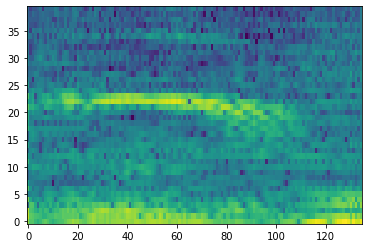

In [ ]:
calltype = calltypes[5]
df_sub = df[df['call_lable']==calltype]
example = df_sub.sample(n=1)
data = example.raw_audio.values[0]
rate = example.samplerate_hz.values[0]
print(calltype)
plt.imshow(example.denoised_stretched_spectrograms.values[0], interpolation='nearest', origin='lower', aspect='auto')

In [ ]:
#Audio(data=data, rate=rate)
filename = calltype+'_example.wav'
librosa.output.write_wav(PROJECT_PATH+'example_wavs/'+filename, data, rate, norm=False)
Audio(data=data, rate=rate)

In [ ]:
def get_audio(wav_loc, start_s, duration_s):
  # SOUNDFOCs are stereo
  if "SOUNDFOC" in wav_loc:
    data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None, mono=False)
    data = np.asfortranarray(data[MEERKAT_CHANNEL[wav_loc],:])
  else:
    data, rate = librosa.load(wav_loc, offset=start_s, duration=duration_s, sr=None)

  if np.issubdtype(type(data[0]), np.integer):
    data = int16_to_float32(data)
  return data

In [ ]:
sr = example.samplerate_hz.values[0]
dur = example.duration_s.values[0]
offset = example.start_s.values[0]
wav_loc = example.original_wav.values[0]

# add padding
dur = dur+0.2


y = get_audio(wav_loc, offset, dur)
Audio(data=y, rate=sr)
filename = calltype+'_example.wav'
librosa.output.write_wav(PROJECT_PATH+'example_wavs/'+filename, y, sr, norm=False)

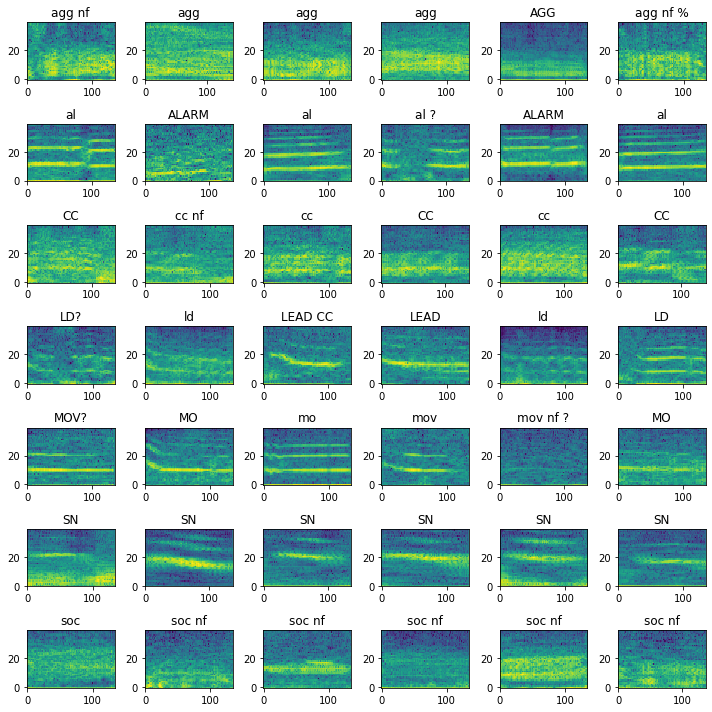

In [ ]:
calltype = calltypes[0]
df_sub = df[df['call_lable']==calltype]
example = df_sub.sample(n=6)
specs=example.denoised_stretched_spectrograms.values

fig = plt.figure(figsize=(10,10))
k=1
for i,calltype in enumerate(calltypes):
  df_sub = df[df['call_lable']==calltype]
  example = df_sub.sample(n=6)
  specs=example.denoised_stretched_spectrograms.values
  labelnames = example.Name.values
  for j,spec in enumerate(specs):
      plt.subplot(7, 6, k)
      plt.imshow(spec, interpolation='nearest', origin='lower', aspect='auto') 
      title = labelnames[j]
      plt.title(title)
      k+=1
plt.tight_layout() 
plt.savefig(FIGURES+'examples_of_all_1.jpg')